In [8]:
from domainbed.datasets.datasets import *
from domainbed.datasets import get_dataset
from domainbed.lib.fast_data_loader import *
from domainbed.structs.args import Args
from domainbed import algorithms
from PIL import Image
import matplotlib.pyplot as plt
from domainbed import hparams_registry
from sconf import Config
import sys
import argparse
import numpy as np
from domainbed.lib import misc 

## Test PACS_generated dataset ##

In [9]:


# Simulate command-line arguments
sys.argv = [
    '--name', 'sagm_test',  # Positional argument 'name'
    # Since 'configs' is empty, we don't add any more positional arguments
    '--algorithm', 'ERM_DiffuseMix',
    '--blended_loss_weight', '0.5',
    '--checkpoint_freq', '100',
    '--data_dir', r'D:\Datasets\diffuseMix_augmented',
    '--dataset', 'PACS_Generated',
    '--deterministic',  # Since it's True
    '--evalmode', 'fast',
    '--fractal_weight', '0.2',
    '--holdout_fraction', '0.2',
    # '--model_save' is None, omit it if default is None
    '--num_slices', '2',
    '--seed', '0',
    '--tb_freq', '10',
    # '--test_envs' is None, omit it if default is None
    '--trial_seed', '110',
    # Additional parameters not handled by argparse will be set later
]


# Define your argument parser
parser = argparse.ArgumentParser(description="Domain generalization")
parser.add_argument("name", type=str)
parser.add_argument("configs", nargs="*")
parser.add_argument("--data_dir", type=str, default="datadir/")
parser.add_argument("--dataset", type=str, default="PACS")
parser.add_argument("--algorithm", type=str, default="ERM")
parser.add_argument(
    "--trial_seed",
    type=int,
    default=0,
    help="Trial number (used for seeding split_dataset and random_hparams).",
)
parser.add_argument("--seed", type=int, default=0, help="Seed for everything else")
parser.add_argument(
    "--steps", type=int, default=None, help="Number of steps. Default is dataset-dependent."
)
parser.add_argument(
    "--checkpoint_freq",
    type=int,
    default=None,
    help="Checkpoint every N steps. Default is dataset-dependent.",
)
parser.add_argument("--test_envs", type=int, nargs="+", default=None)
parser.add_argument("--holdout_fraction", type=float, default=0.2)
parser.add_argument("--model_save", default=None, type=int, help="Model save start step")
parser.add_argument("--deterministic", action="store_true")
parser.add_argument("--tb_freq", type=int, default=10)
parser.add_argument("--debug", action="store_true", help="Run w/ debug mode")
parser.add_argument("--show", action="store_true", help="Show args and hparams w/o run")
parser.add_argument(
    "--evalmode",
    default="fast",
    help="[fast, all]. if fast, ignore train_in datasets in evaluation time.",
)
parser.add_argument("--prebuild_loader", action="store_true", help="Pre-build eval loaders")
parser.add_argument("--fractal_weight", type=float, default=0.2)
parser.add_argument("--blended_loss_weight", type=float, default=0.5)
parser.add_argument("--num_slices", type=int, default=2)

# Parse arguments
args, left_argv = parser.parse_known_args()
args: Args = args  # Assuming you have an Args class or type
hparams = hparams_registry.default_hparams(args.algorithm, args.dataset)

keys = ["config.yaml"] + args.configs
keys = [open(key, encoding="utf8") for key in keys]
hparams = Config(*keys, default=hparams)
hparams.argv_update(left_argv)

In [10]:
test_envs = ["P"]
algorithm_class = algorithms.get_algorithm_class(args.algorithm)
dataset, in_splits, out_splits = get_dataset(test_envs, args, hparams, algorithm_class)

In [11]:
n_envs = len(dataset)
iterator = misc.SplitIterator(test_envs)
batch_sizes = np.full([n_envs], hparams["batch_size"], dtype=int)

train_loaders = [
        InfiniteDataLoader(
            dataset=env,
            weights=env_weights,
            batch_size=(int)(batch_size),
            num_workers=dataset.N_WORKERS,
        )
        for (env, env_weights), batch_size in iterator.train(zip(in_splits, batch_sizes))
    ]

In [13]:
train_minibatches_iterator = zip(*train_loaders)
batches_dictlist = next(train_minibatches_iterator)
batches = misc.merge_dictlist(batches_dictlist)

In [14]:
device = 'cuda'
batches = {
    key: [
        tensor.to(device) if isinstance(tensor, torch.Tensor) else [x.to(device) for x in tensor]
        for tensor in tensorlist
    ] 
    for key, tensorlist in batches.items()
}


inputs = {**batches, "step": 1}


In [23]:
x = inputs['x']

In [24]:
def check_shape(x, layer=1):
    print(f"layer{layer}: {len(x)}")
    try:
        check_shape(x[0], layer+1)
    except:
        return

In [30]:
def min_max_normalize(standardized_image):
    min_val = standardized_image.min()
    max_val = standardized_image.max()

    if max_val != min_val:
        scaled_image = (standardized_image - min_val) / (max_val - min_val)
    else:
        # If all values are the same, set the image to zeros
        scaled_image = torch.zeros_like(standardized_image)
    return scaled_image


layer1: 4
layer2: 2
layer3: 32
layer4: 3
layer5: 224
layer6: 224


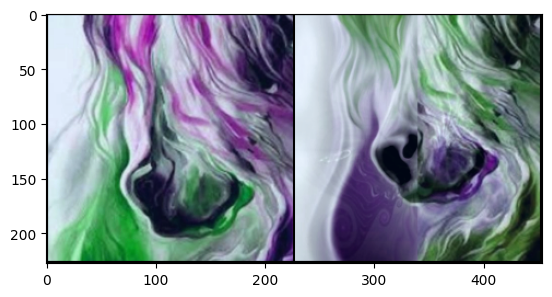

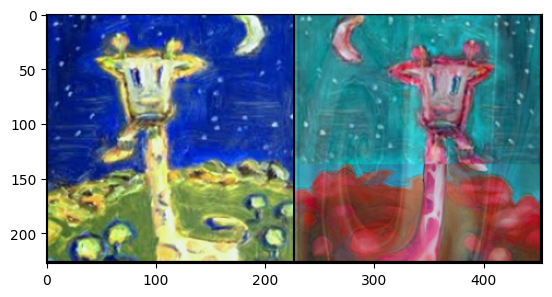

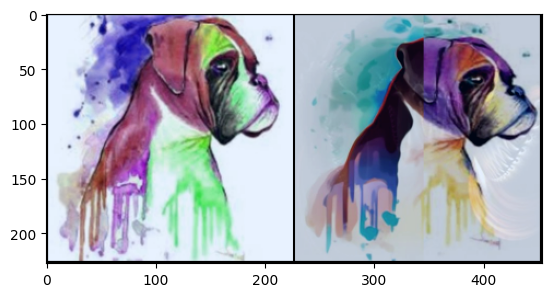

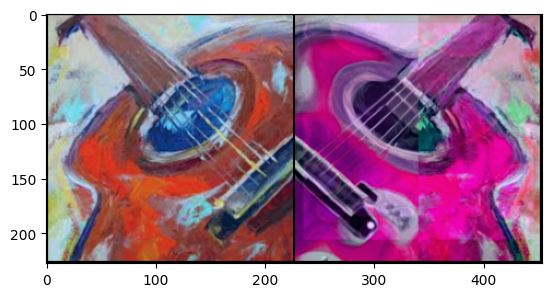

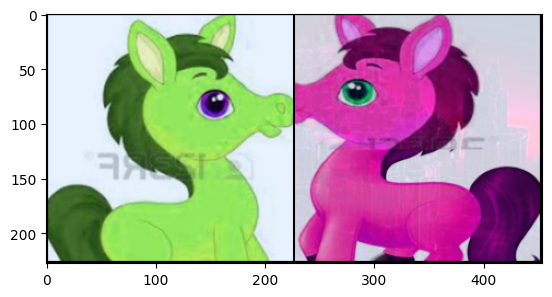

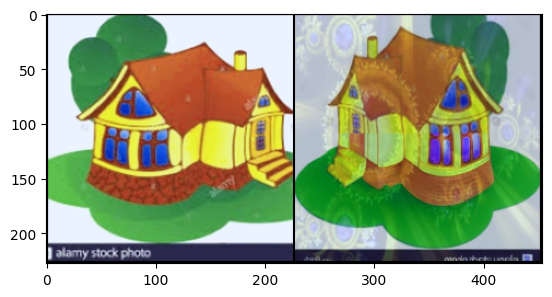

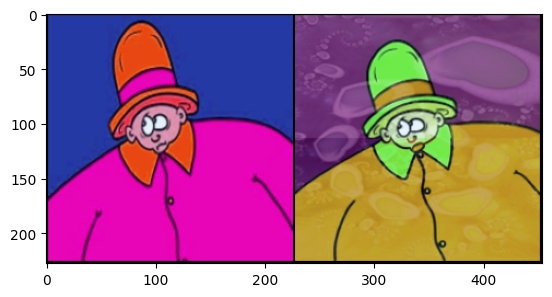

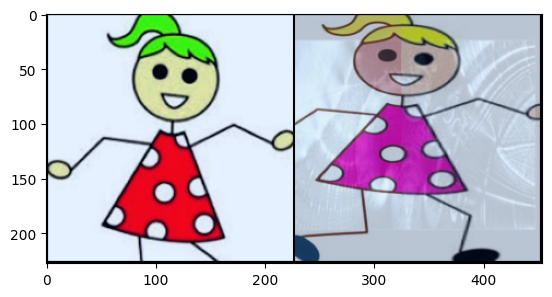

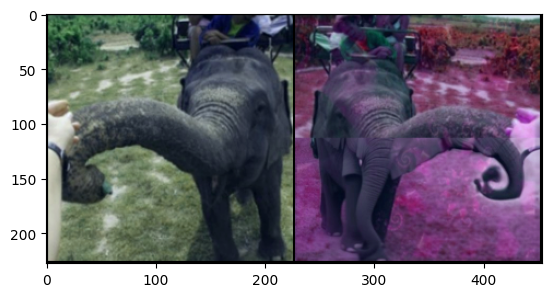

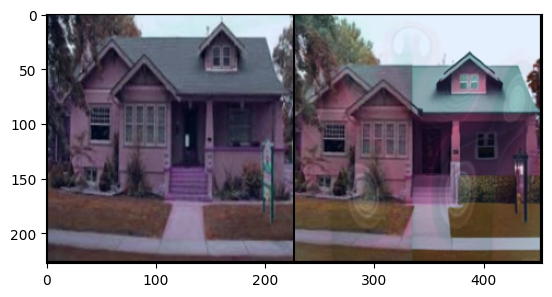

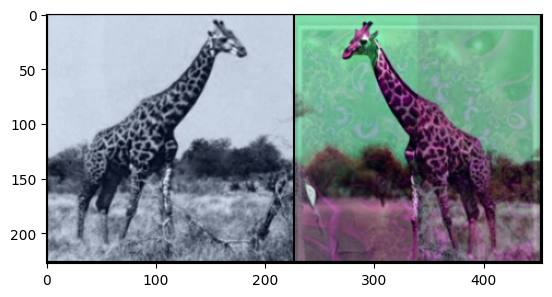

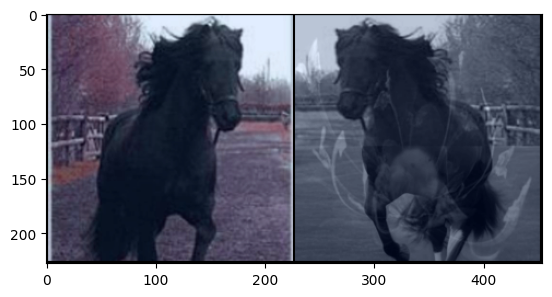

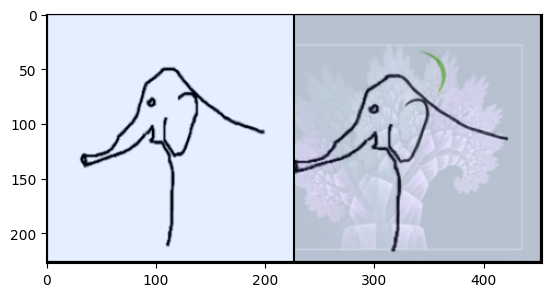

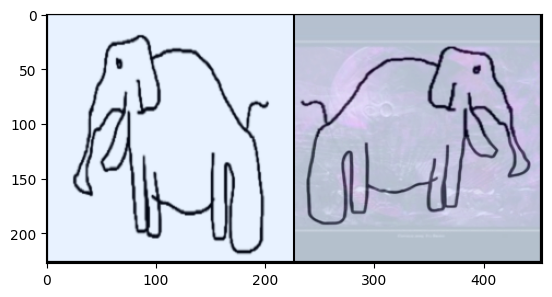

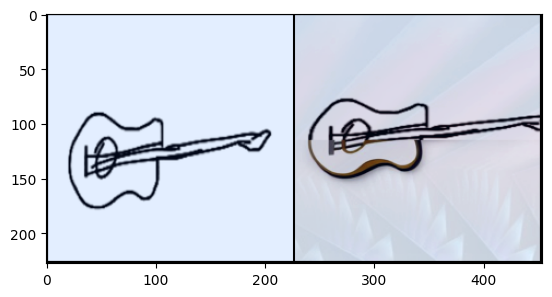

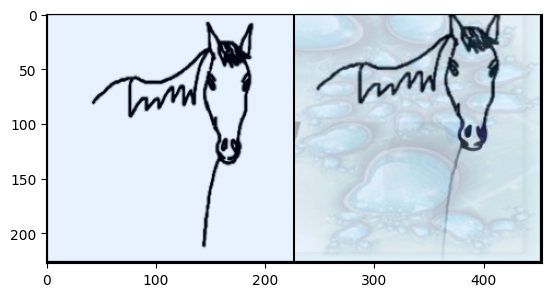

In [31]:
import torchvision
check_shape(x)
for k in range(len(x)):
    x_c = x[k] # (2, 32, 3, 224, 224)
    x_original = x_c[0]   # (32, 3, 224, 224)
    x_augmented = x_c[1]  # (32, 3, 224, 224)

    for i in range(len(x)):
        original_image = x_original[i] # (3, 224, 224)
        transformed_image = x_augmented[i] # (3, 224, 224)
        
        # From visualization, the images are standardized, not min-max normalized
        # Apply min-max normalize to approximately scale to [0, 1], then scale back to [0, 255]
        original_image = min_max_normalize(original_image)
        transformed_image = min_max_normalize(transformed_image)
        
        # Keep everything on GPU
        original_image = original_image * 255  # Scale to [0, 255]
        transformed_image = transformed_image * 255

        # Ensure images are clamped to valid range
        original_image = original_image.clamp(0, 255).to(torch.uint8)  # Shape [3, 224, 224]
        transformed_image = transformed_image.clamp(0, 255).to(torch.uint8)

        # Stack images on GPU
        batch_images = torch.stack([original_image, transformed_image])  # Shape [2, 3, 224, 224]

        # Create a grid from the batch directly on GPU
        img_grid = torchvision.utils.make_grid(batch_images)
        
        img_grid_vis = img_grid.cpu().permute(1, 2, 0)
        plt.imshow(img_grid_vis)
        plt.show()